## by Sangmyeong Lee, Julie Seo

---


In [ ]:
!pip install numpy==1.24.4 --force-reinstall


In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Data range
start_date = "2021-01-01"
end_date = "2025-04-08"

# TSLA price data
tsla = yf.download("TSLA", start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
tsla.columns = tsla.columns.get_level_values(0)  
tsla.columns = [f"TSLA_{col}" for col in tsla.columns]

# NASDAQ index data
nasdaq = yf.download("^NDX", start=start_date, end=end_date)[['Close']]
nasdaq.columns = nasdaq.columns.get_level_values(0)  
nasdaq.rename(columns={'Close': 'NASDAQ_Index'}, inplace=True)

tsla.columns = tsla.columns.get_level_values(0)  
nasdaq.columns = nasdaq.columns.get_level_values(0)

# Cleaning
for df in [tsla, nasdaq]:
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index(inplace=True)

# Merge
df = tsla.join(nasdaq, how='inner')
df.dropna(inplace=True)

# Target
df['TSLA_target'] = df['TSLA_Close'].shift(-1)

# Check data
df.dropna(inplace=True)
df.to_csv("tsla_multivariate_dataset.csv")

print("Dataset saved as 'tsla_multivariate_dataset.csv'")
print("Shape:", df.shape)
print(df.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Dataset saved as 'tsla_multivariate_dataset.csv'
Shape: (1069, 7)
             TSLA_Open   TSLA_High    TSLA_Low  TSLA_Close  TSLA_Volume  \
Date                                                                      
2025-03-31  249.309998  260.559998  243.360001  259.160004    134008900   
2025-04-01  263.799988  277.450012  259.250000  268.459991    146486900   
2025-04-02  254.600006  284.989990  251.270004  282.760010    212787800   
2025-04-03  265.290009  276.299988  261.510010  267.279999    136174300   
2025-04-04  255.380005  261.000000  236.000000  239.429993    181229400   

            NASDAQ_Index  TSLA_target  
Date                                   
2025-03-31  19278.449219   268.459991  
2025-04-01  19436.419922   282.760010  
2025-04-02  19581.779297   267.279999  
2025-04-03  18521.470703   239.429993  
2025-04-04  17397.699219   233.289993  


# Model 1
---

## Data preprocessing

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Add 10-day and 20-day moving averages
df['MA10'] = df['TSLA_Close'].rolling(window=10).mean()  
df['MA20'] = df['TSLA_Close'].rolling(window=20).mean()  

# Fill NaN values using backward fill
df[['MA10', 'MA20']] = df[['MA10', 'MA20']].bfill() 


In [ ]:

# MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'Close', 'MA10', and 'MA20' columns to bring values between 0 and 1
df[['TSLA_Close', 'MA10', 'MA20']] = scaler.fit_transform(df[['TSLA_Close', 'MA10', 'MA20']])



## Feature engineering

In [ ]:
import numpy as np

x_data = []
y_data = []

# Construct input features and target data
for i in range(60, len(df)):
    x_data.append(
        np.column_stack((
            df['TSLA_Close'].values[i-60:i],   
            df['MA10'].values[i-60:i],   
            df['MA20'].values[i-60:i]    
        ))
    )
    y_data.append(df['TSLA_Close'].values[i])  

x_data = np.array(x_data)
y_data = np.array(y_data)

print(f"x_data shape: {x_data.shape}")
print(f"y_data shape: {y_data.shape}")


x_data shape: (1009, 60, 3)
y_data shape: (1009,)


In [ ]:

# Split the dataset into training, validation, and test sets
train_size = int(len(x_data) * 0.8)  
val_size = int(len(x_data) * 0.1)    

# Assign the training, validation, and test sets
x_train, y_train = x_data[:train_size], y_data[:train_size]  
x_val, y_val = x_data[train_size:train_size+val_size], y_data[train_size:train_size+val_size] 
x_test, y_test = x_data[train_size+val_size:], y_data[train_size+val_size:]  

# Shapes
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (807, 60, 3), y_train shape: (807,)
x_val shape: (100, 60, 3), y_val shape: (100,)
x_test shape: (102, 60, 3), y_test shape: (102,)


## LSTM Modeling

In [ ]:
from keras.models import Sequential  
from keras.layers import LSTM, Dense, Input  

# Build the LSTM model
model = Sequential()
model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))  # Define the input shape using Input()
model.add(LSTM(128, return_sequences=True))  # First LSTM layer with 128 units
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer with 64 units
model.add(Dense(25))  # Fully connected Dense layer with 25 units
model.add(Dense(1))  # Output layer with 1 unit

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')  # Use Adam optimizer and mean squared error as the loss function

# Train the model
history = model.fit(
    x_train, y_train,               
    batch_size=32,                 
    epochs=50,                      
    validation_data=(x_val, y_val)  
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0245 - val_loss: 0.0037
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0

In [ ]:
# Use the trained model to predict prices for the test set
predictions = model.predict(x_test)

# Convert predicted prices back to the original scale
restored_predictions = scaler.inverse_transform(
    np.column_stack((predictions, np.zeros((predictions.shape[0], 2))))  
)[:, 0]  

# Convert actual prices back to the original scale
restored_y_test = scaler.inverse_transform(
    np.column_stack((y_test, np.zeros((y_test.shape[0], 2))))  
)[:, 0]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


## Model evaluation

In [8]:
# Calculate RMSE for the restored prices (absolute error)
rmse_restored = np.sqrt(np.mean((restored_predictions - restored_y_test) ** 2))

# Calculate the mean of actual prices in the test set
mean_real_price = restored_y_test.mean()

# Calculate relative RMSE as a percentage of the mean actual price
relative_rmse = (rmse_restored / mean_real_price) * 100

# Display relative RMSE as a percentage
print(f"RMSE: {rmse_restored:.2f}")
print(f"Relative RMSE: {relative_rmse:.2f}%")

RMSE: 16.71
Relative RMSE: 4.81%


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


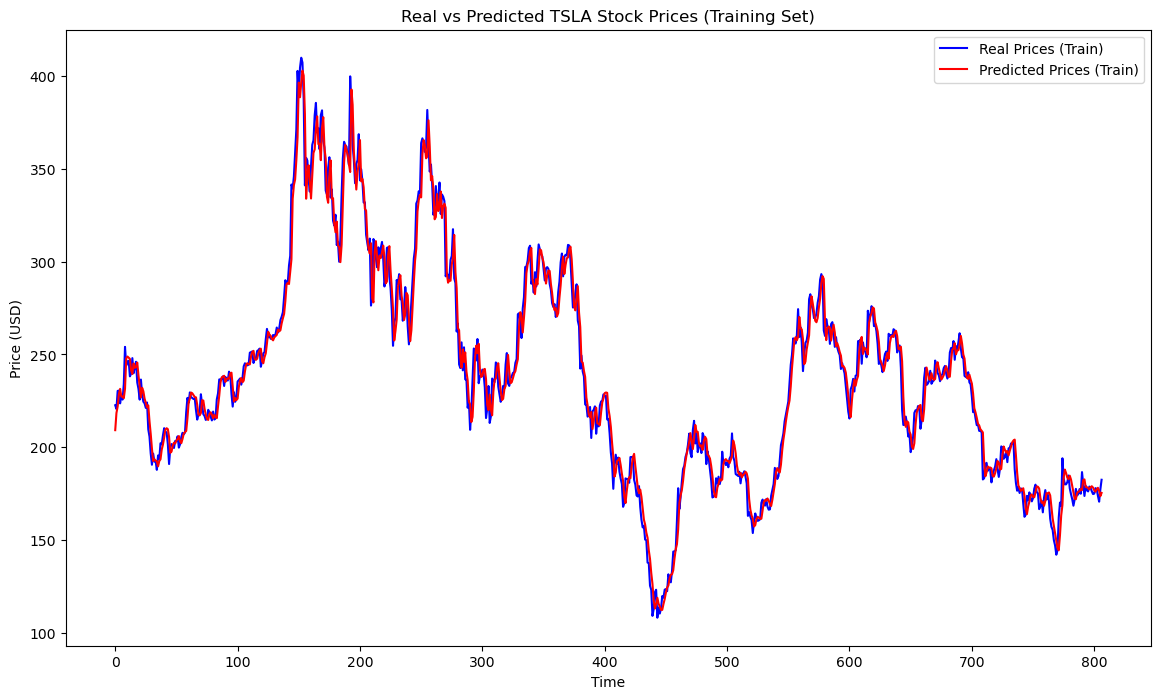

In [ ]:
import matplotlib.pyplot as plt

# Visualize Training Set Results

train_predictions = model.predict(x_train)

# Reverse the scaling transformation for predicted values
restored_train_predictions = scaler.inverse_transform(
    np.column_stack((train_predictions, np.zeros((train_predictions.shape[0], 2))))
)[:, 0]

# Reverse the scaling transformation for actual prices
restored_y_train = scaler.inverse_transform(
    np.column_stack((y_train, np.zeros((y_train.shape[0], 2))))
)[:, 0]


plt.figure(figsize=(14, 8))
plt.plot(restored_y_train, label='Real Prices (Train)', color='blue')  
plt.plot(restored_train_predictions, label='Predicted Prices (Train)', color='red') 
plt.title("Real vs Predicted TSLA Stock Prices (Training Set)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

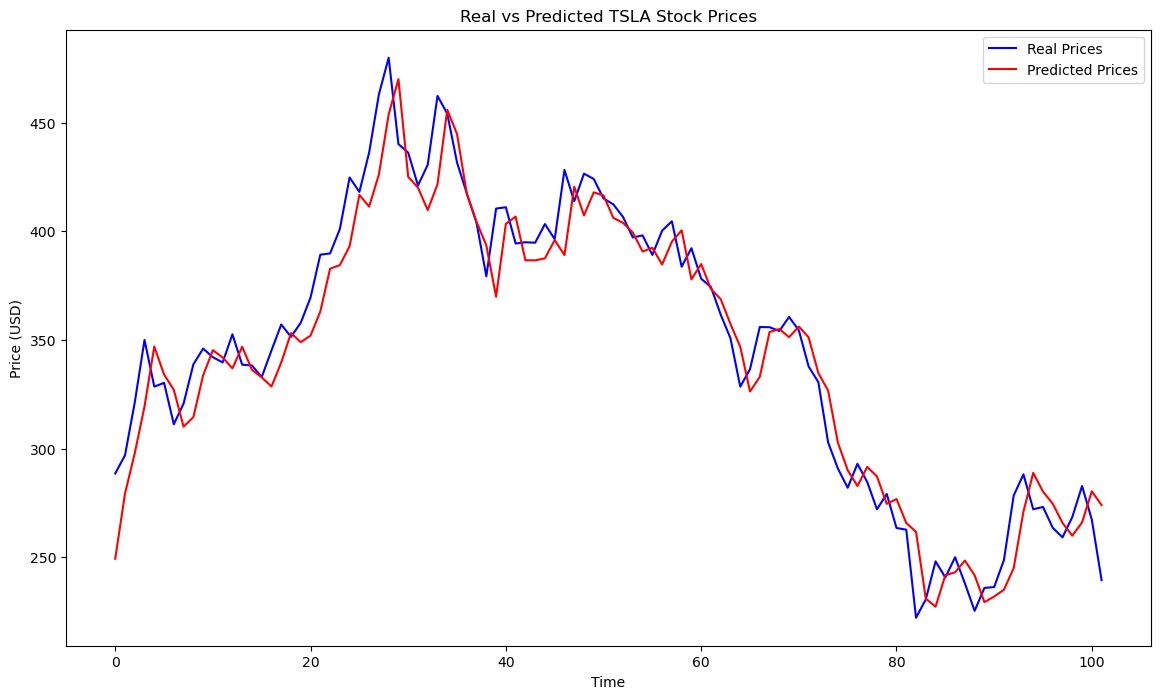

In [ ]:
# Visualize Test Set Results

plt.figure(figsize=(14, 8))

# Plot actual TSLA prices from the test set
plt.plot(restored_y_test, label='Real Prices', color='blue')

# Plot predicted TSLA prices from the test set
plt.plot(restored_predictions, label='Predicted Prices', color='red')

plt.title("Real vs Predicted TSLA Stock Prices")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

Naive RMSE: 15.16
Directional Accuracy: 54.46%


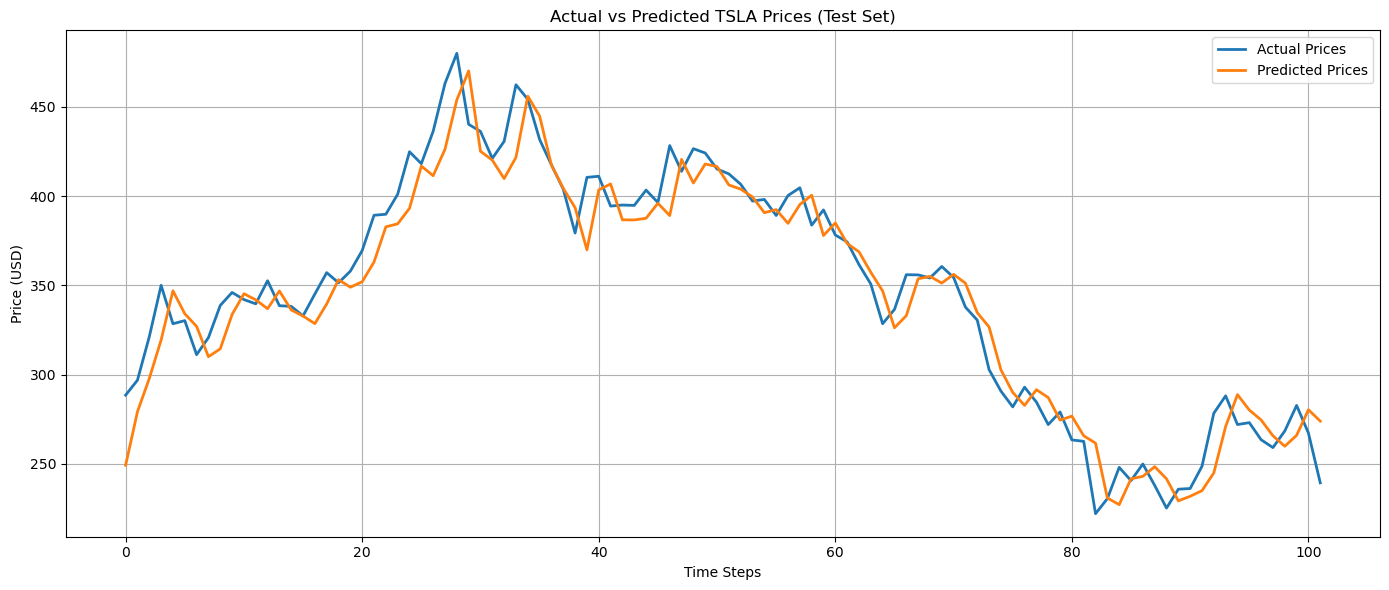

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Naive RMSE 
naive_pred = restored_y_test[:-1]
actual = restored_y_test[1:]
naive_rmse = np.sqrt(np.mean((actual - naive_pred) ** 2))
print(f"Naive RMSE: {naive_rmse:.2f}")

# Directional Accuracy
actual_diff = np.diff(restored_y_test)
pred_diff = np.diff(restored_predictions)
directional_matches = np.sum(np.sign(actual_diff) == np.sign(pred_diff))
directional_accuracy = directional_matches / len(actual_diff) * 100
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

plt.figure(figsize=(14, 6))
plt.plot(restored_y_test, label='Actual Prices', linewidth=2)
plt.plot(restored_predictions, label='Predicted Prices', linewidth=2)
plt.title("Actual vs Predicted TSLA Prices (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# MAE 
mae = mean_absolute_error(restored_y_test, restored_predictions)
print(f"MAE (Model 1): {mae:.2f}")

# MAPE 
mape = np.mean(np.abs((restored_y_test - restored_predictions) / restored_y_test)) * 100
print(f"MAPE (Model 1): {mape:.2f}%")

MAE (Model 1): 124.20
MAPE (Model 1): 59.07%


---

## Model 2

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# features and target 
feature_cols = ['TSLA_Open', 'TSLA_High', 'TSLA_Low', 'TSLA_Close', 'TSLA_Volume', 'NASDAQ_Index']
target_col = 'TSLA_target'

data = df[feature_cols + [target_col]].copy()

# Normalize 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences 
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, :-1])  
        y.append(data[i, -1])             
    return np.array(X), np.array(y)

SEQ_LEN = 30  
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (831, 30, 6)
y_train shape: (831,)


/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0459 - val_loss: 0.0085
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - val_loss: 0.0062
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0241 - val_loss: 0.0131
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - val_loss: 0.0116
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0091 - val_loss: 0.0048
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - val_loss: 0.0024
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - val_loss: 0.0023
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0051 - val_l

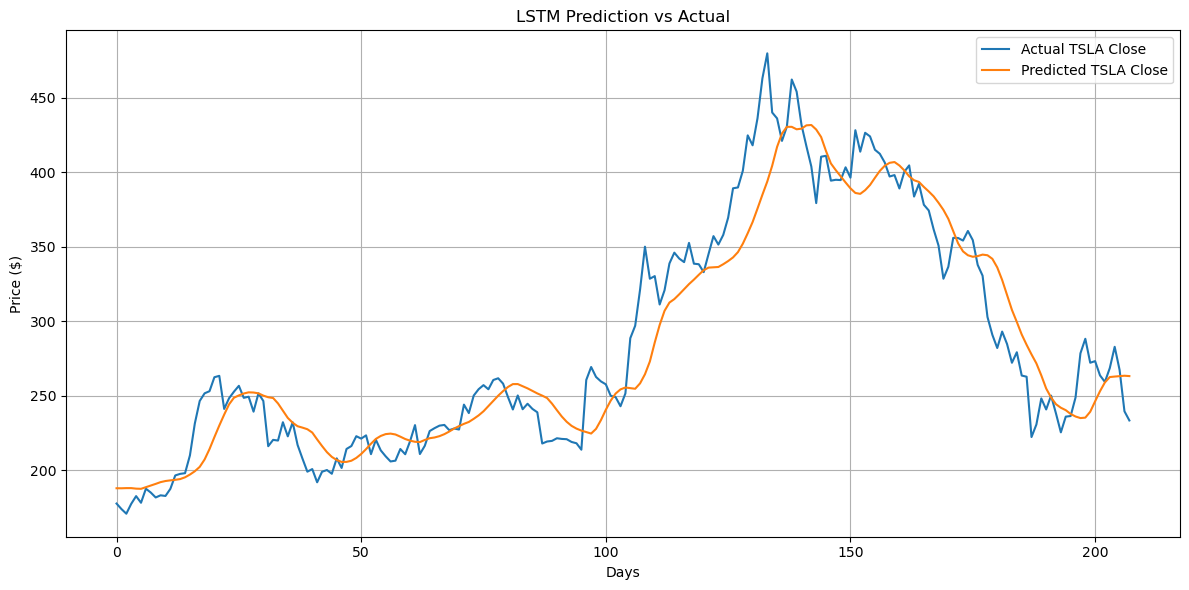

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Build model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, shuffle=False)

# Predict
y_pred_scaled = model.predict(X_test)

# Inverse scale
target_index = -1  
target_min = scaler.data_min_[target_index]
target_max = scaler.data_max_[target_index]

y_pred = y_pred_scaled * (target_max - target_min) + target_min
y_test_actual = y_test * (target_max - target_min) + target_min

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual TSLA Close")
plt.plot(y_pred, label="Predicted TSLA Close")
plt.title("LSTM Prediction vs Actual")
plt.xlabel("Days")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_actual, y_pred)
print(f"MAPE (Model 2): {mape:.2f}%")

MAPE (Model 2): 29.91%


In [ ]:
import numpy as np
# Directional accuracy (Mdoel 2)
true = np.array(y_test_actual).flatten()
pred = np.array(y_pred).flatten()

min_len = min(len(true), len(pred))
true = true[:min_len]
pred = pred[:min_len]

true_diff = np.diff(true)
pred_diff = np.diff(pred)

direction_match = (np.sign(true_diff) == np.sign(pred_diff)).astype(int)

directional_accuracy = direction_match.mean()

print(f" Directional Accuracy: {directional_accuracy * 100:.2f}%")

 Directional Accuracy: 55.07%


In [ ]:
import numpy as np

# Relative RMSE 
mean_price = np.mean(y_test_actual)
relative_rmse = (rmse / mean_price) * 100

print(f"Relative RMSE: {relative_rmse:.2f}%")

# Naive RMSE 
naive_pred = y_test_actual[:-1]
actual = y_test_actual[1:]
naive_rmse = np.sqrt(np.mean((actual - naive_pred) ** 2))

print(f"Naive RMSE: {naive_rmse:.2f}")

Relative RMSE: 8.86%
Naive RMSE: 12.81


---

# Mock trading

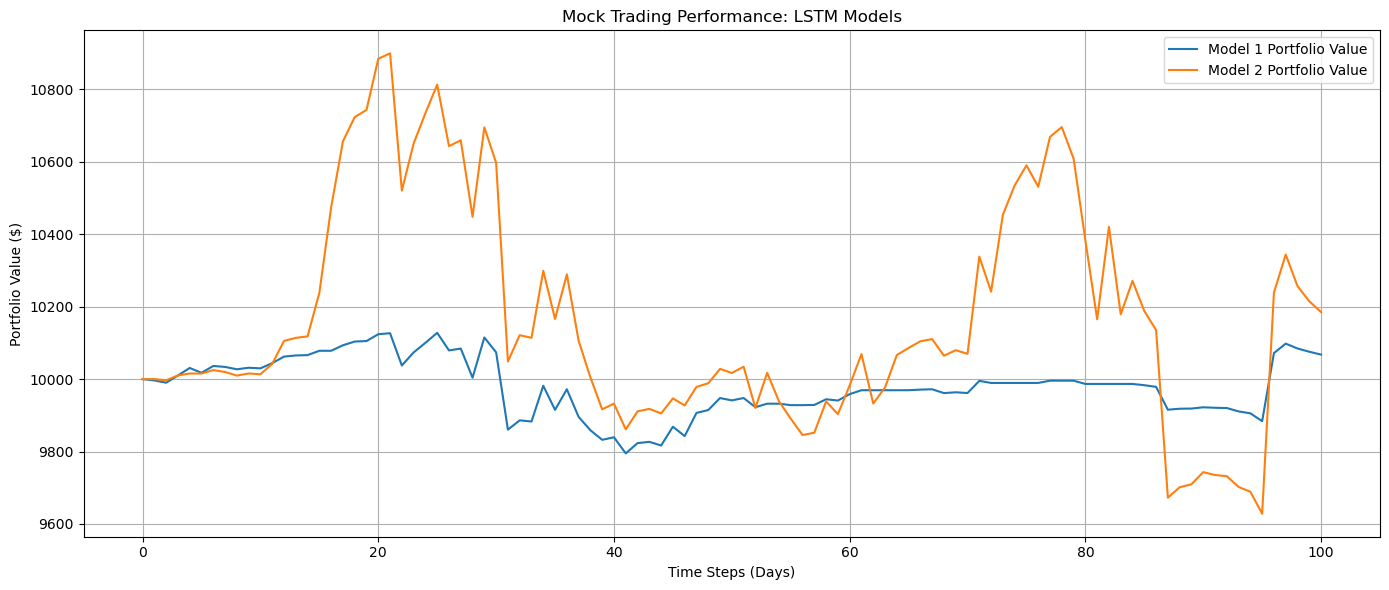

Model 1 Final Portfolio Value: $10,067.65
Model 2 Final Portfolio Value: $10,185.12


In [ ]:
restored_predictions_1 = scaler.inverse_transform(
    np.column_stack((predictions, np.zeros((predictions.shape[0], 6))))
)[:, 0]

restored_y_test_1 = scaler.inverse_transform(
    np.column_stack((y_test, np.zeros((y_test.shape[0], 6))))
)[:, 0]

restored_predictions_2 = y_pred.flatten()
restored_y_test_2 = y_test_actual.flatten()

min_len = min(len(restored_predictions_1), len(restored_predictions_2), len(restored_y_test_1), len(restored_y_test_2))

restored_predictions_1 = restored_predictions_1[:min_len]
restored_predictions_2 = restored_predictions_2[:min_len]
restored_y_test = restored_y_test_1[:min_len]  

def simulate_trading(predictions, actuals, starting_cash=10000):
    cash = starting_cash
    position = 0  
    portfolio_values = []

    for i in range(len(predictions) - 1):  
        today_price = actuals[i]
        pred_diff = predictions[i+1] - predictions[i]

        if pred_diff > 0 and cash >= today_price:
            cash -= today_price
            position += 1
        elif pred_diff < 0 and position > 0:
            cash += today_price
            position -= 1

        total_value = cash + position * today_price
        portfolio_values.append(total_value)

    return portfolio_values


min_len = min(len(restored_predictions_1), len(restored_predictions_2), len(restored_y_test))
restored_predictions_1 = restored_predictions_1[:min_len]
restored_predictions_2 = restored_predictions_2[:min_len]
restored_y_test = restored_y_test[:min_len]

portfolio_1 = simulate_trading(restored_predictions_1, restored_y_test)
portfolio_2 = simulate_trading(restored_predictions_2, restored_y_test)

plt.figure(figsize=(14, 6))
plt.plot(portfolio_1, label='Model 1 Portfolio Value')
plt.plot(portfolio_2, label='Model 2 Portfolio Value')
plt.title("Mock Trading Performance: LSTM Models")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Model 1 Final Portfolio Value: ${portfolio_1[-1]:,.2f}")
print(f"Model 2 Final Portfolio Value: ${portfolio_2[-1]:,.2f}")

---

# ARIMA model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("tsla_multivariate_dataset.csv", index_col=0, parse_dates=True)
tsla_close = df["TSLA_Close"]

split = int(len(tsla_close) * 0.8)
train_data = tsla_close[:split]
test_data = tsla_close[split:]

model_auto = auto_arima(
    train_data,
    seasonal=True,
    m=5,
    d=1,
    D=1,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
print("Best ARIMA Order:", model_auto.order)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[5]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=6751.949, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=6537.465, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.35 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=6750.982, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=6430.530, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=1.03 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=6429.510, Time=0.08 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=6537.889, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=6430.552, Time=0.13 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=6432.644, Time=0.15 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=6431.494, Time=0.22 s

In [2]:
tsla_close.tail()

Date
2025-03-31    259.160004
2025-04-01    268.459991
2025-04-02    282.760010
2025-04-03    267.279999
2025-04-04    239.429993
Name: TSLA_Close, dtype: float64

In [12]:

# Fit Final SARIMAX
model = SARIMAX(train_data, order=model_auto.order)
model_fit = model.fit(disp=False)

# training set
train_pred = model_fit.fittedvalues

# test set
forecast_result = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Evaluate 
rmse = np.sqrt(mean_squared_error(test_data, forecast_mean))
r2 = r2_score(test_data, forecast_mean)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2 Score: {r2:.2f}")


Test RMSE: 131.56
Test R^2 Score: -1.73


/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model

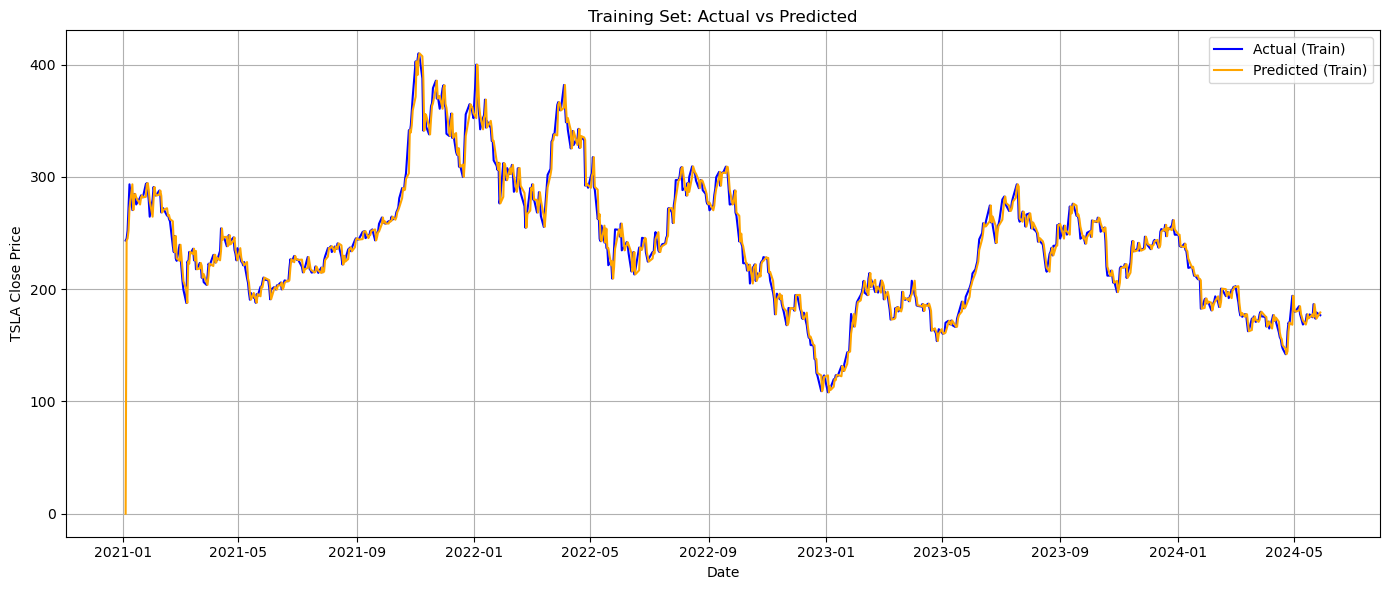

In [7]:
# --- 9. Plot actual vs predicted (train) ---
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label="Actual (Train)", color="blue")
plt.plot(train_data.index, train_pred, label="Predicted (Train)", color="orange")
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

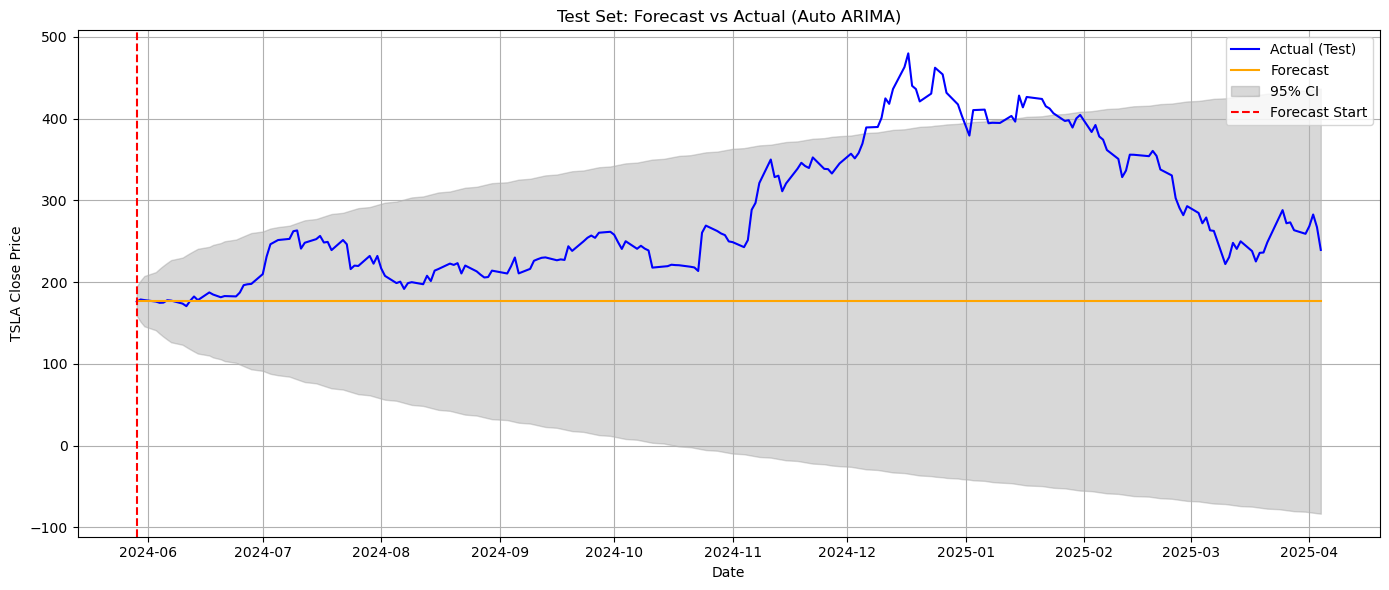

In [8]:
# Plot forecast (test) 
plt.figure(figsize=(14, 6))
plt.plot(test_data.index, test_data, label="Actual (Test)", color="blue")
plt.plot(test_data.index, forecast_mean, label="Forecast", color="orange")
plt.fill_between(test_data.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label="95% CI")
plt.axvline(test_data.index[0], linestyle='--', color='red', label="Forecast Start")
plt.title("Test Set: Forecast vs Actual (Auto ARIMA)")
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

# Change target (residual)

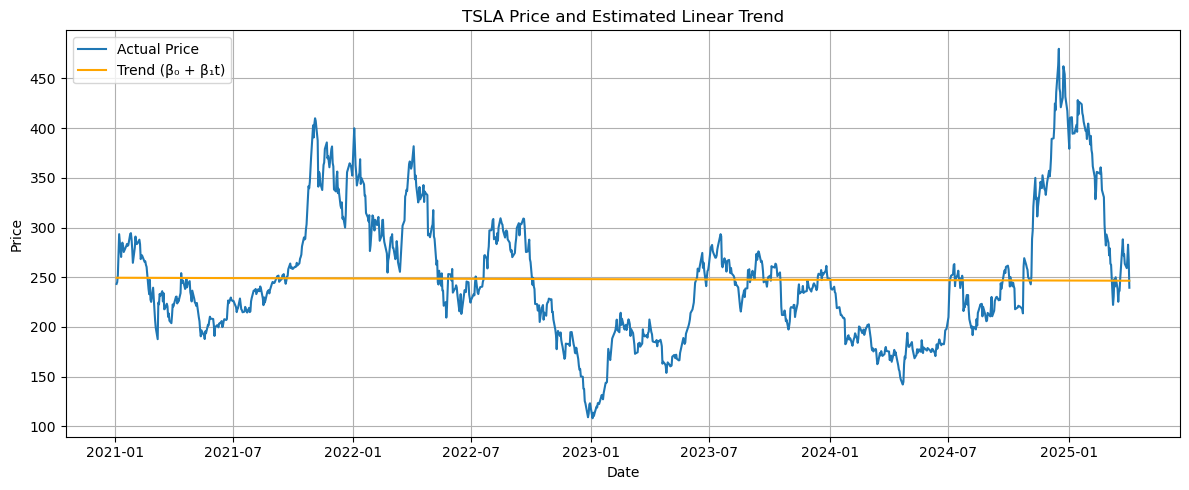

                            OLS Regression Results                            
Dep. Variable:             TSLA_Close   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1933
Date:                Mon, 14 Apr 2025   Prob (F-statistic):              0.660
Time:                        12:59:40   Log-Likelihood:                -5960.9
No. Observations:                1069   AIC:                         1.193e+04
Df Residuals:                    1067   BIC:                         1.194e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        249.4708      3.909     63.818      0.0

In [13]:
from statsmodels.api import OLS, add_constant

df = pd.read_csv("tsla_multivariate_dataset.csv", index_col=0, parse_dates=True)
df = df[['TSLA_Close']].copy()

# Encode time as integer
df['t'] = np.arange(len(df))

# Linear trend fit
X = add_constant(df['t'])
model_trend = OLS(df['TSLA_Close'], X).fit()

# Predicted trend
df['Trend'] = model_trend.predict(X)

# Detrended series
df['Z_t'] = df['TSLA_Close'] - df['Trend']

# Plot trend
plt.figure(figsize=(12, 5))
plt.plot(df['TSLA_Close'], label='Actual Price')
plt.plot(df['Trend'], label='Trend (β₀ + β₁t)', color='orange')
plt.title("TSLA Price and Estimated Linear Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

print(model_trend.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6199.679, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6192.789, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6194.008, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6194.017, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6190.848, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6195.681, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.369 seconds


/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/samlee/Anaconda/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


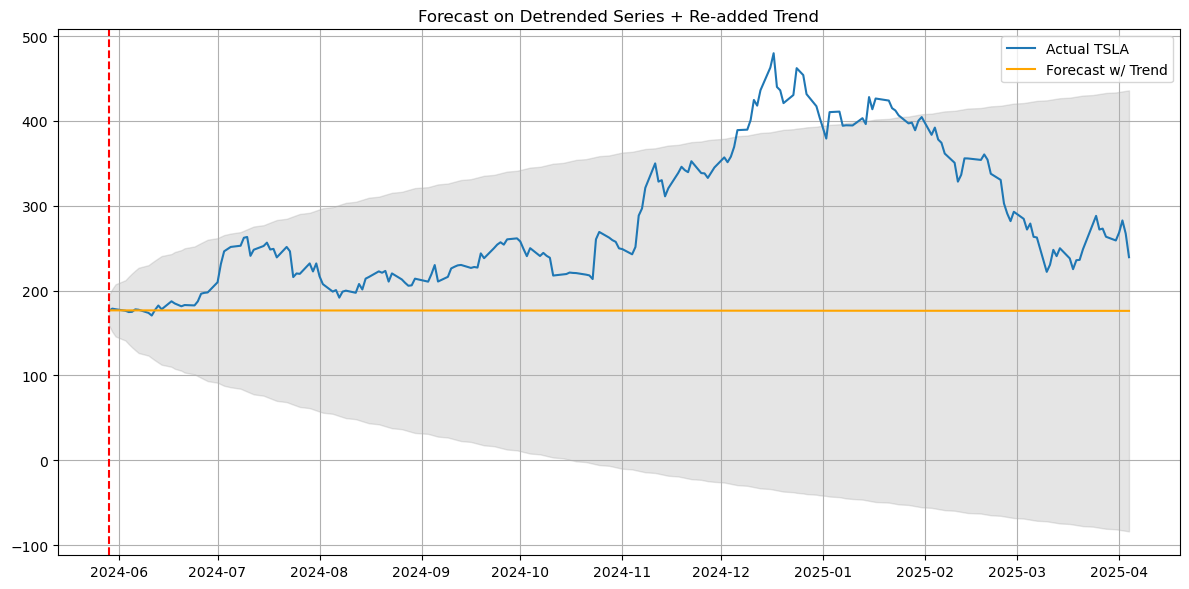

In [14]:
from pmdarima import auto_arima

train_size = int(len(df) * 0.8)
train_resid = df['Z_t'][:train_size]
test_resid = df['Z_t'][train_size:]

# Fit ARIMA on residual
arima_model = auto_arima(train_resid, seasonal=False, trace=True, stepwise=True, suppress_warnings=True)

# Forecast residuals
n_test = len(test_resid)
forecast_resid, conf_int = arima_model.predict(n_periods=n_test, return_conf_int=True)

# Add trend back
forecast_with_trend = forecast_resid + df['Trend'].iloc[train_size:].values
actual = df['TSLA_Close'].iloc[train_size:]

# Plot
plt.figure(figsize=(12,6))
plt.plot(actual.index, actual, label='Actual TSLA')
plt.plot(actual.index, forecast_with_trend, label='Forecast w/ Trend', color='orange')
plt.fill_between(actual.index, 
                 forecast_with_trend - (conf_int[:,1] - forecast_resid), 
                 forecast_with_trend + (conf_int[:,1] - forecast_resid),
                 alpha=0.2, color='gray')
plt.axvline(actual.index[0], linestyle='--', color='red')
plt.title("Forecast on Detrended Series + Re-added Trend")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

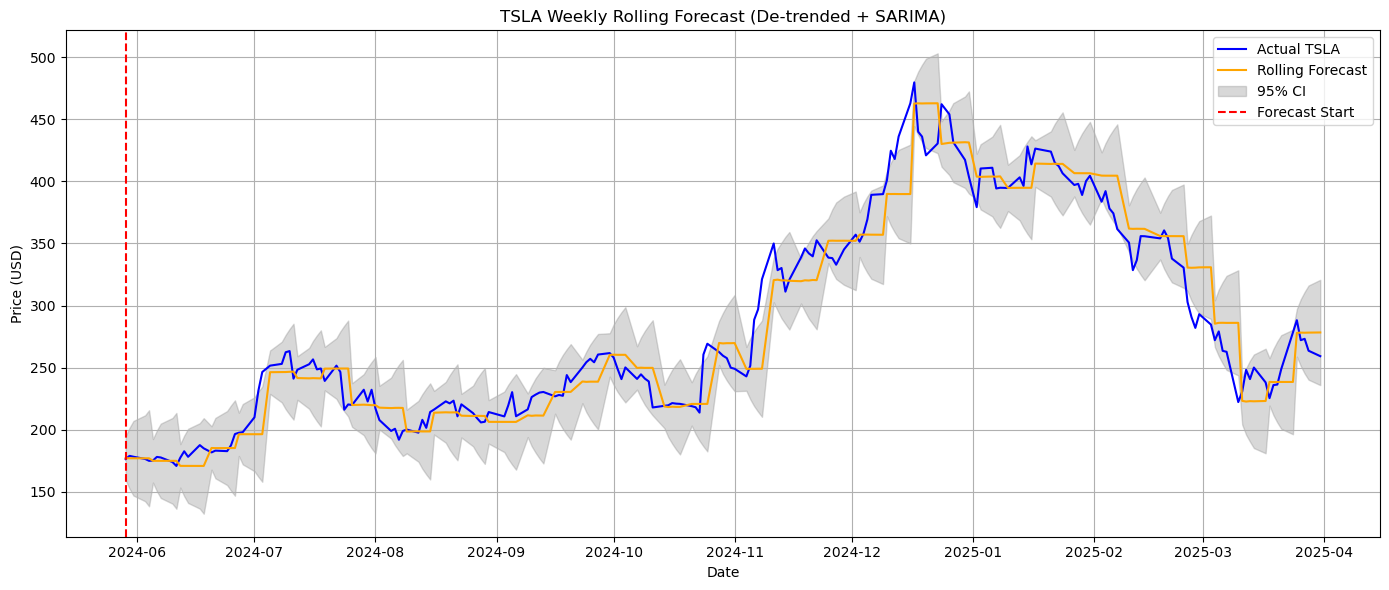

RMSE: 19.88
R^2 Score: 0.94


In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv("tsla_multivariate_dataset.csv", index_col=0, parse_dates=True)
tsla_close = df['TSLA_Close']

# Create time index for trend 
t = np.arange(len(tsla_close)).reshape(-1, 1)

# Fit linear trend: x_t = beta_0 + beta_1 * t 
trend_model = LinearRegression().fit(t, tsla_close.values)
beta_0 = trend_model.intercept_
beta_1 = trend_model.coef_[0]
trend = trend_model.predict(t)

# De-trend the data: Z_t = X_t - (beta_0 + beta_1 * t) 
residuals = tsla_close.values - trend

# Split train and test (rolling weekly) 
train_size = int(len(residuals) * 0.8)
step_size = 5  # 5 trading days

train_resid = residuals[:train_size]
test_resid = residuals[train_size:]
test_trend = trend[train_size:]
test_index = tsla_close.index[train_size:]

# lists to collect predictions 
rolling_preds = []
rolling_uppers = []
rolling_lowers = []

# Rolling weekly forecast 
for i in range(0, len(test_resid) - step_size + 1, step_size):
    # Train SARIMA on current residuals
    model = SARIMAX(train_resid, order=(1, 1, 1), seasonal_order=(1, 0, 1, 5),
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # Forecast 1 week ahead
    forecast_obj = model_fit.get_forecast(steps=step_size)
    pred_resid = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    # Save predictions + intervals
    rolling_preds.extend(pred_resid)
    rolling_lowers.extend(conf_int[:, 0])
    rolling_uppers.extend(conf_int[:, 1])

    # Update training residuals with new observations
    train_resid = np.concatenate([train_resid, test_resid[i:i+step_size]])

# Full forecast by adding trend back 
pred_index = test_index[:len(rolling_preds)]
trend_slice = test_trend[:len(rolling_preds)]

final_forecast = rolling_preds + trend_slice
lower_bound = rolling_lowers + trend_slice
upper_bound = rolling_uppers + trend_slice
actual = tsla_close[train_size:][:len(rolling_preds)]

plt.figure(figsize=(14, 6))
plt.plot(actual.index, actual, label="Actual TSLA", color="blue")
plt.plot(actual.index, final_forecast, label="Rolling Forecast", color="orange")
plt.fill_between(actual.index, lower_bound, upper_bound, alpha=0.3, color='gray', label="95% CI")
plt.axvline(actual.index[0], linestyle='--', color='red', label="Forecast Start")
plt.title("TSLA Weekly Rolling Forecast (De-trended + SARIMA)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse = mean_squared_error(actual, final_forecast, squared=False)
r2 = r2_score(actual, final_forecast)
print(f"RMSE: {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

In [19]:
# Relative RMSE 
mean_actual = np.mean(actual)
relative_rmse = (rmse / mean_actual) * 100

# Naive RMSE 
naive_preds = actual.shift(1).dropna()
naive_actual = actual[1:]
naive_rmse = np.sqrt(mean_squared_error(naive_actual, naive_preds))

# Output 
print(f"ARIMA RMSE: {rmse:.2f}")
print(f"Relative RMSE: {relative_rmse:.2f}%")
print(f"Naive RMSE: {naive_rmse:.2f}")

ARIMA RMSE: 19.88
Relative RMSE: 7.05%
Naive RMSE: 12.50


Final Portfolio Value: $10,072.18
Total Profit: $72.18
Profit Percentage: 0.72%


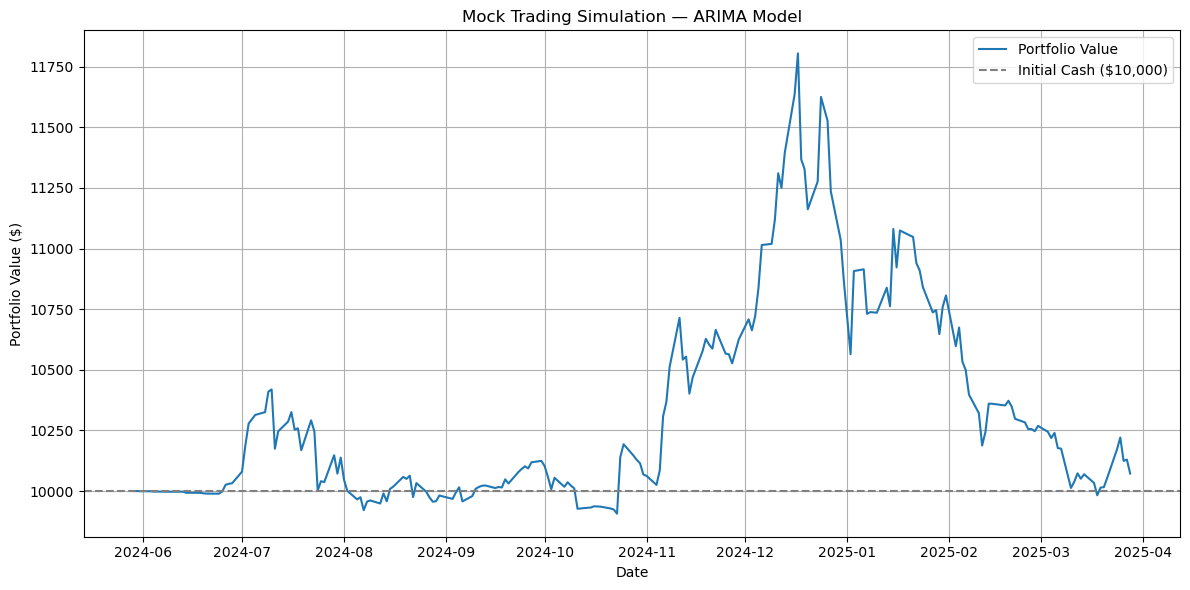

In [21]:
initial_cash = 10000
cash = initial_cash
shares_held = 0
portfolio_value = []

forecast_prices = np.array(final_forecast)
actual_prices = np.array(actual)

# Simulate trading 
for i in range(len(forecast_prices) - 1):  
    today_price = actual_prices[i]
    tomorrow_forecast = forecast_prices[i + 1]

    if tomorrow_forecast > forecast_prices[i] and cash >= today_price:
        shares_held += 1
        cash -= today_price

    elif tomorrow_forecast < forecast_prices[i] and shares_held > 0:
        shares_held -= 1
        cash += today_price

    # Calculate current portfolio value
    total_value = cash + shares_held * today_price
    portfolio_value.append(total_value)

# portfolio value 
final_value = portfolio_value[-1]
profit = final_value - initial_cash
profit_pct = (profit / initial_cash) * 100

# results 
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Profit: ${profit:,.2f}")
print(f"Profit Percentage: {profit_pct:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(actual.index[:len(portfolio_value)], portfolio_value, label="Portfolio Value")
plt.axhline(initial_cash, color='gray', linestyle='--', label="Initial Cash ($10,000)")
plt.title("Mock Trading Simulation — ARIMA Model")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()